# Evaluating performance of scalable GPLVM models for dimensionality reduction of single-cell genomics datasets
---

In [79]:
from TrainFunction import plot_cormap, scatter_Plot,CorrelationScores_PT
import scanpy as sc
import os, torch
import numpy as np
import pandas as pd
import pickle as pkl
import scipy.sparse as sp
from collections import namedtuple
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import sklearn

In [3]:
## Load output of trained GPLVMs (12 in total)

In [4]:
gastrulation=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/gastrulation_PCA.h5ad')

In [5]:
gastrulation_random=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/gastrulation_random.h5ad')

| Dataset     | Gastrulation|
| ----------- | ----------- |
| No of Cells | 89267        |
| No of Genes | 1488       |
|Time         | 9 minutes       |

In [6]:
forebrain=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/forebrain_PCA.h5ad')

In [7]:
forebrain

AnnData object with n_obs × n_vars = 1720 × 2454
    obs: 'Clusters', 'cellcycle_pseudotime'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'likelihood_state_dict', 'model_state_dict', 'pca'
    obsm: 'X_BGPLVM_latent', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [8]:
forebrain_random=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/forebrain_random.h5ad')

| Dataset     | Forebrain|
| ----------- | ----------- |
| No of Cells | 1720       |
| No of Genes | 2454     |
|Time         | ~13 minutes       |

In [9]:
bonemarrow=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/bonemarrow_PCA.h5ad')

In [10]:
bonemarrow_random=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/bonemarrow_random.h5ad')

| Dataset     | Bonemarrow|
| ----------- | ----------- |
| No of Cells | 5780        |
| No of Genes |  2030|    |
|Time         |~12 mins        |

In [11]:
iPSC=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/iPSC_PCA.h5ad')

In [12]:
iPSC_random=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/iPSC_random.h5ad')

| Dataset     |iPSC|
| ----------- | ----------- |
| No of Cells |    22188    |
| No of Genes | 1404 |    |
|Time         |~8:50 mins        |

In [13]:
pancreas=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/pancreas_PCA.h5ad')

In [14]:
pancreas_random=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/pancreas_random.h5ad')

| Dataset     |Pancreas|
| ----------- | ----------- |
| No of Cells | 3696       |
| No of Genes | 1939 |    |
|Time         |~11 mins        |

In [15]:
pbmc=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/pbmc_PCA.h5ad')

In [16]:
pbmc_random=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/pbmc_random.h5ad')

| Dataset     |iPSC|
| ----------- | ----------- |
| No of Cells |    65877  |
| No of Genes | 1721    |
|Time         |~10 mins        |

## Do we require non-random initialization of the GPLVM model?

In the GASPACHO paper we used PCA as the inital state, but is this really necessary?

### 1. GPLVM initialized from the PCA doesn't learn anything different

In [17]:
## ... correlation between PCs and LVs with and without initialization

In [18]:
datasets=[bonemarrow,bonemarrow_random, forebrain,forebrain_random, gastrulation, gastrulation_random, iPSC, iPSC_random, pancreas
          ,pancreas_random,pbmc,pbmc_random]

In [328]:
gastrulation

AnnData object with n_obs × n_vars = 89267 × 1488
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'cellcycle_pseudotime', 'clusters_gplvm_PcaInit', 'clusters_PC', 'clusters_gplvm_randomInit'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'likelihood_state_dict', 'model_state_dict', 'pca', 'PCA', 'umap', 'gplvm_PCA', 'leiden', 'celltype_colors'
    obsm: 'X_BGPLVM_latent', 'X_pca', 'X_umap', 'X_umap_pca', 'X_umap_gplvm_random', 'X_umap_gplvm_PC'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'PCA_distances', 'PCA_connecti

In [19]:
len(datasets)

12

In [88]:
Names=['bonemarrow','bonemarrow_random', 'forebrain','forebrain_random', 'gastrulation', 'gastrulation_random', 'iPSC', 
       'iPSC_random', 'pancreas','pancreas_random','pbmc','pbmc_random']

In [89]:
data= pd.DataFrame(columns=["Correlation", "dataset", "Init"])

In [159]:
for i in range(12):
    tempDf = pd.DataFrame(columns=['Correlation','dataset','Init'])
    #tempDf['Correlation'] = CorrelationScores_PT(datasets[i],7)
    tempDf = tempDf.assign(dataset=Names[i])
    if '_' in Names[i]:
        tempDf['Correlation'] = CorrelationScores_PT(datasets[i],7)
        tempDf = tempDf.assign(dataset=Names[i])
        tempDf= tempDf.assign(Init="random")
        data = pd.concat([data,tempDf])
    else:
        tempDf['Correlation'] = CorrelationScores_PT(datasets[i],7)
        tempDf = tempDf.assign(dataset=Names[i])
        tempDf= tempDf.assign(Init="PCA")
        data = pd.concat([data,tempDf])   

In [160]:
d=data.copy()
d=d.replace('pbmc_random','pbmc')
d=d.replace('bonemarrow_random','bonemarrow')
d=d.replace('iPSC_random','iPSC')
d=d.replace('forebrain_random','forebrain')
d=d.replace('pancreas_random','pancreas')
d=d.replace('gastrulation_random','gastrulation')

In [161]:
d

,Correlation,dataset,Init
0,0.976897,bonemarrow,PCA
1,0.924954,bonemarrow,PCA
2,0.921351,bonemarrow,PCA
3,0.896406,bonemarrow,PCA
4,0.671090,bonemarrow,PCA
...,...,...,...
2,0.125026,pbmc,random
3,0.273314,pbmc,random
4,0.115919,pbmc,random
5,0.284187,pbmc,random


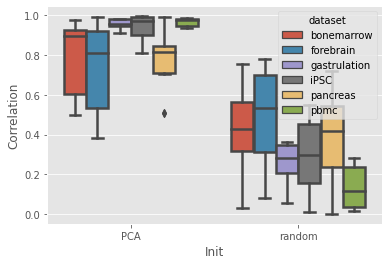

In [162]:
ax = sns.boxplot(x="Init", y="Correlation", hue="dataset",
                 data=d, linewidth=2.5)

### 2. Does GPLVM trained with random initialization capture cell type identity?

As a first impression we can visualize UMAP embeddings from all the dimensionality reductions (random GPLVM, initialized GPLM, PCA) and assess qualitatively if we see a separation between cells of the same cell type

In [41]:
## code for UMAP plots ##

In [42]:
 #sc.tl.pca(adata, svd_solver='arpack')

In [36]:
def plot_umap(adata,adata_random):
    '''
    plots umaps based on the GP(random-init), GP(PCA-init) and PC components, takes as input adata objects with trained GP models 
    based on PC and random initialisation respectively 
    '''
    #del adata.obsm['X_umap'] #delete exisiting UMAPs
    #del adata_random.obsm['X_umap']
    
    sc.pp.neighbors(adata, use_rep="X_pca", key_added='PCA') #use_rep=any values from obsm
    sc.tl.umap(adata,neighbors_key='PCA')
    adata.obsm["X_umap_pca"] = adata.obsm["X_umap"].copy()
    
    sc.pp.neighbors(adata_random, use_rep="X_BGPLVM_latent", key_added='gplvm_random') 
    sc.tl.umap(adata_random, neighbors_key='gplvm_random')
    adata.obsm["X_umap_gplvm_random"] = adata_random.obsm["X_umap"].copy()
    adata_random.obsm["X_umap_gplvm_rand"] = adata_random.obsm["X_umap"].copy()

    sc.pp.neighbors(adata, use_rep="X_BGPLVM_latent", key_added='gplvm_PCA') 
    sc.tl.umap(adata, neighbors_key='gplvm_PCA')
    adata.obsm["X_umap_gplvm_PC"] = adata.obsm["X_umap"].copy()

    
    sc.tl.leiden(adata, neighbors_key='gplvm_PCA', key_added='clusters_gplvm_PcaInit')
    sc.tl.leiden(adata_random, neighbors_key='gplvm_random', key_added='clusters_gplvm_randomInit')
    sc.tl.leiden(adata, neighbors_key='PCA', key_added='clusters_PC')
    adata.obs["clusters_gplvm_randomInit"] = adata_random.obs["clusters_gplvm_randomInit"].copy()



    
    return adata
    
    

In [37]:
plot_umap(forebrain,forebrain_random)

AnnData object with n_obs × n_vars = 1720 × 2454
    obs: 'Clusters', 'cellcycle_pseudotime', 'clusters_gplvm_PcaInit', 'clusters_PC', 'clusters_gplvm_randomInit'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'likelihood_state_dict', 'model_state_dict', 'pca', 'PCA', 'umap', 'gplvm_PCA', 'leiden'
    obsm: 'X_BGPLVM_latent', 'X_pca', 'X_umap', 'X_umap_pca', 'X_umap_gplvm_random', 'X_umap_gplvm_PC'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'PCA_distances', 'PCA_connectivities', 'gplvm_PCA_distances', 'gplvm_PCA_connectivities'

In [38]:
plot_umap(gastrulation, gastrulation_random)

AnnData object with n_obs × n_vars = 89267 × 1488
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'cellcycle_pseudotime', 'clusters_gplvm_PcaInit', 'clusters_PC', 'clusters_gplvm_randomInit'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'likelihood_state_dict', 'model_state_dict', 'pca', 'PCA', 'umap', 'gplvm_PCA', 'leiden'
    obsm: 'X_BGPLVM_latent', 'X_pca', 'X_umap', 'X_umap_pca', 'X_umap_gplvm_random', 'X_umap_gplvm_PC'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'PCA_distances', 'PCA_connectivities', 'gplvm_PCA

In [39]:
plot_umap(bonemarrow,bonemarrow_random)

AnnData object with n_obs × n_vars = 5780 × 2030
    obs: 'clusters', 'palantir_pseudotime', 'cellcycle_pseudotime', 'clusters_gplvm_PcaInit', 'clusters_PC', 'clusters_gplvm_randomInit'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'hvg', 'likelihood_state_dict', 'model_state_dict', 'pca', 'PCA', 'umap', 'gplvm_PCA', 'leiden'
    obsm: 'X_BGPLVM_latent', 'X_pca', 'X_tsne', 'X_umap', 'X_umap_pca', 'X_umap_gplvm_random', 'X_umap_gplvm_PC'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'PCA_distances', 'PCA_connectivities', 'gplvm_PCA_distances', 'gplvm_PCA_connectivities'

In [40]:
plot_umap(iPSC,iPSC_random)

AnnData object with n_obs × n_vars = 22188 × 1404
    obs: 'nfrag', 'ngene', 'donor', 'mt', 'ercc', 'plate', 'cellcycle_pseudotime', 'clusters_gplvm_PcaInit', 'clusters_PC', 'clusters_gplvm_randomInit'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'likelihood_state_dict', 'model_state_dict', 'pca', 'PCA', 'umap', 'gplvm_PCA', 'leiden'
    obsm: 'X_BGPLVM_latent', 'X_init', 'X_pca', 'X_umap', 'X_umap_pca', 'X_umap_gplvm_random', 'X_umap_gplvm_PC'
    varm: 'PCs'
    obsp: 'PCA_distances', 'PCA_connectivities', 'gplvm_PCA_distances', 'gplvm_PCA_connectivities'

In [41]:
plot_umap(pbmc,pbmc_random)

AnnData object with n_obs × n_vars = 65877 × 1721
    obs: 'celltype', 'cellcycle_pseudotime', 'clusters_gplvm_PcaInit', 'clusters_PC', 'clusters_gplvm_randomInit'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'likelihood_state_dict', 'model_state_dict', 'pca', 'PCA', 'umap', 'gplvm_PCA', 'leiden'
    obsm: 'X_BGPLVM_latent', 'X_pca', 'X_tsne', 'X_umap', 'X_umap_pca', 'X_umap_gplvm_random', 'X_umap_gplvm_PC'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'PCA_distances', 'PCA_connectivities', 'gplvm_PCA_distances', 'gplvm_PCA_connectivities'

In [42]:
plot_umap(pancreas,pancreas_random)

AnnData object with n_obs × n_vars = 3696 × 1939
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'cellcycle_pseudotime', 'clusters_gplvm_PcaInit', 'clusters_PC', 'clusters_gplvm_randomInit'
    var: 'highly_variable_genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'hvg', 'likelihood_state_dict', 'model_state_dict', 'neighbors', 'pca', 'PCA', 'umap', 'gplvm_PCA', 'leiden'
    obsm: 'X_BGPLVM_latent', 'X_pca', 'X_umap', 'X_umap_pca', 'X_umap_gplvm_random', 'X_umap_gplvm_PC'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances', 'PCA_distances', 'PCA_connectivities', 'gplvm_PCA_distances', 'gplvm_PCA_connectivities'

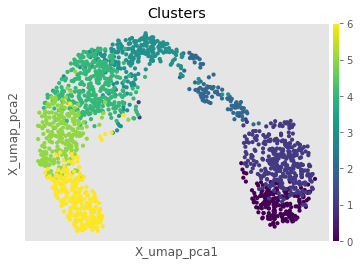

In [44]:
sc.pl.embedding(forebrain, "X_umap_pca", color=[ 'Clusters'])

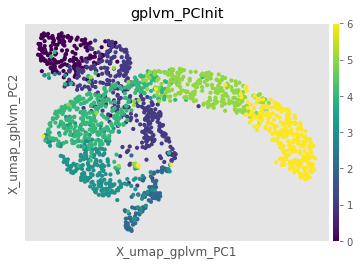

In [45]:
sc.pl.embedding(forebrain, "X_umap_gplvm_PC", color=[ 'Clusters'], title="gplvm_PCInit") #PCA

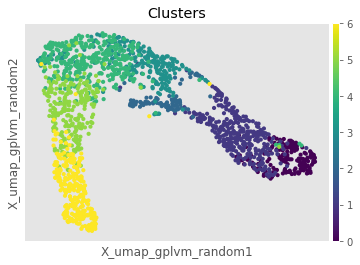

In [46]:
sc.pl.embedding(forebrain, "X_umap_gplvm_random", color=['Clusters']) #PCA

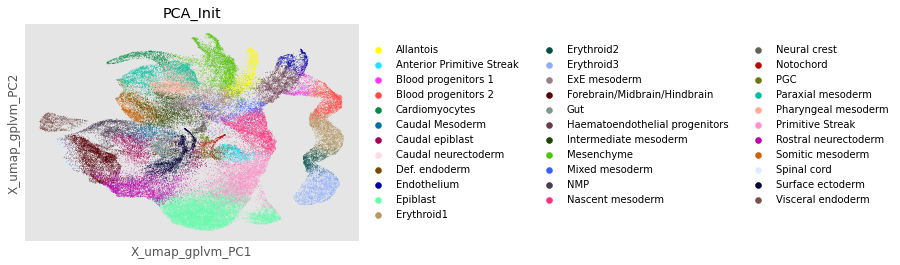

In [47]:
sc.pl.embedding(gastrulation, "X_umap_gplvm_PC", color=[ 'celltype'], title="PCA_Init")

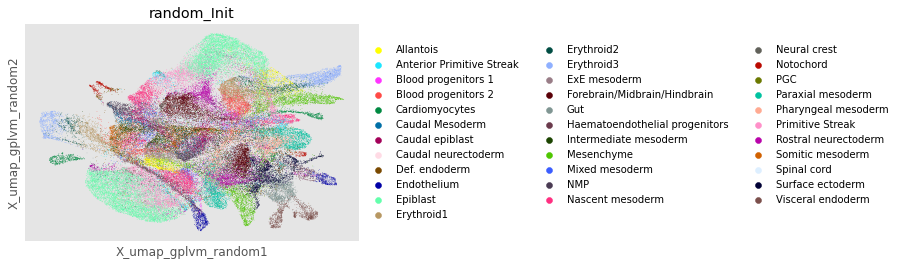

In [48]:
sc.pl.embedding(gastrulation, "X_umap_gplvm_random", color=[ 'celltype'], title="random_Init")

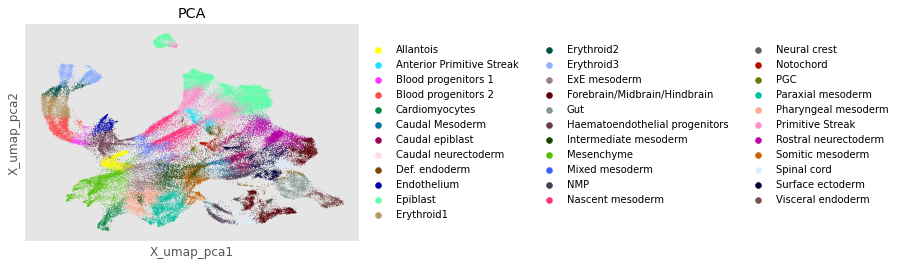

In [49]:
sc.pl.embedding(gastrulation, "X_umap_pca", color=[ 'celltype'], title="PCA")

In [50]:
gastrulation

AnnData object with n_obs × n_vars = 89267 × 1488
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'cellcycle_pseudotime', 'clusters_gplvm_PcaInit', 'clusters_PC', 'clusters_gplvm_randomInit'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'likelihood_state_dict', 'model_state_dict', 'pca', 'PCA', 'umap', 'gplvm_PCA', 'leiden', 'celltype_colors'
    obsm: 'X_BGPLVM_latent', 'X_pca', 'X_umap', 'X_umap_pca', 'X_umap_gplvm_random', 'X_umap_gplvm_PC'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'PCA_distances', 'PCA_connecti

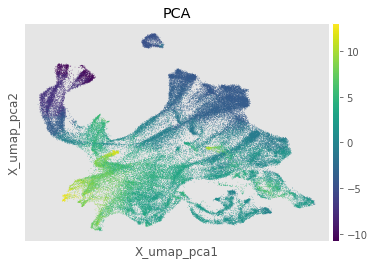

In [51]:
sc.pl.embedding(gastrulation, "X_umap_pca", color=[ 'cellcycle_pseudotime'], title="PCA")

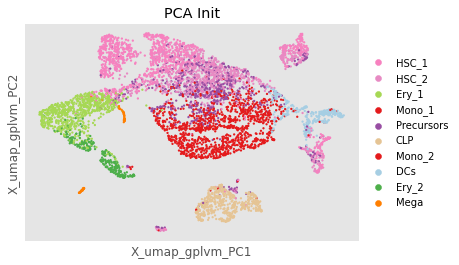

In [52]:
gp_pca=sc.pl.embedding(bonemarrow, "X_umap_gplvm_PC", color=['clusters'], title="PCA Init")

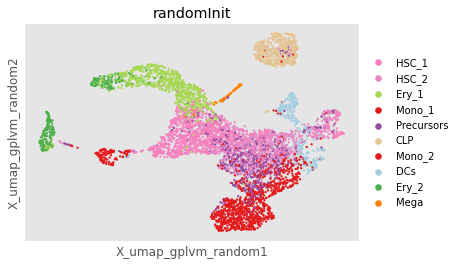

In [53]:
gp_rand=sc.pl.embedding(bonemarrow, "X_umap_gplvm_random", color=[ 'clusters'], title= "randomInit")

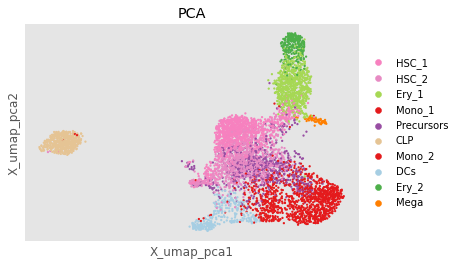

In [54]:
pca=sc.pl.embedding(bonemarrow, "X_umap_pca", color=[ 'clusters'], title="PCA")

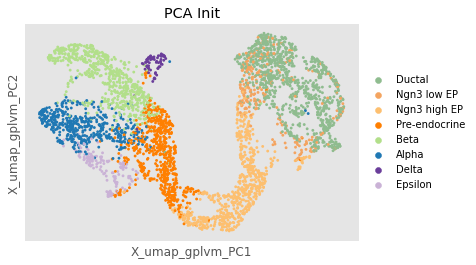

In [55]:
gp_pca=sc.pl.embedding(pancreas, "X_umap_gplvm_PC", color=['clusters'], title="PCA Init")

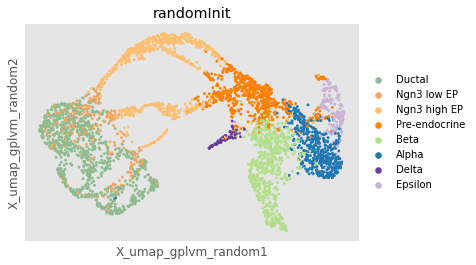

In [56]:
sc.pl.embedding(pancreas, "X_umap_gplvm_random", color=['clusters'], title="randomInit") #PCA

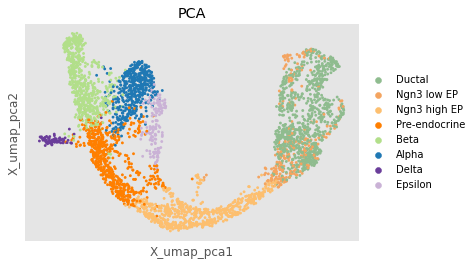

In [57]:
gp_pca=sc.pl.embedding(pancreas, "X_umap_pca", color=['clusters'], title="PCA")

In [58]:
forebrain.obs['celltype']=forebrain.obs['Clusters']
pancreas.obs['celltype']=pancreas.obs['clusters']
bonemarrow.obs['celltype']=bonemarrow.obs['clusters']
pancreas.obs['celltype']=pancreas.obs['clusters']

In [80]:
def randScore(adata):
    '''
    calculates the rand index score to get an idea of the agreement between clusters based on ground truth (celltype in obs) 
    and the clusters obtained via PCA and laent variable UMAPs..(??)
    '''
    input=[['ARI_random_init'],['ARI_gplvm_init'],['ARI_pca']]
    input[0].append(sklearn.metrics.adjusted_rand_score(adata.obs['celltype'], adata.obs['clusters_gplvm_randomInit']))
    input[1].append(sklearn.metrics.adjusted_rand_score(adata.obs['celltype'], adata.obs['clusters_gplvm_PcaInit']))
    input[2].append(sklearn.metrics.adjusted_rand_score(adata.obs['celltype'], adata.obs['clusters_PC']))
                                                   
    return input
    
    

In [300]:
ds = [gastrulation,bonemarrow,forebrain, pancreas, pbmc]
scores=[['gastrulation'],['bonemarrow'],['forebrain'], ['pancreas'], ['pbmc']]
for i in range(len(ds)):
    adata = ds[i]
    
    ARI = randScore(adata)
    scores[i].append(ARI)

In [306]:
def NMI_Scores(adata):
    '''
    calculates the rand index score to get an idea of the agreement between clusters based on ground truth (celltype in obs) 
    and the clusters obtained via PCA and laent variable UMAPs..(??)
    '''
    input=[['ARI_random_init'],['ARI_gplvm_init'],['ARI_pca']]
    input[0].append(sklearn.metrics.adjusted_mutual_info_score(adata.obs['celltype'], adata.obs['clusters_gplvm_randomInit']))
    input[1].append(sklearn.metrics.adjusted_mutual_info_score(adata.obs['celltype'], adata.obs['clusters_gplvm_PcaInit']))
    input[2].append(sklearn.metrics.adjusted_mutual_info_score(adata.obs['celltype'], adata.obs['clusters_PC']))
                                                   
    return input
    

In [307]:
ds = [gastrulation,bonemarrow,forebrain, pancreas, pbmc]
NMI_scores=[['gastrulation'],['bonemarrow'],['forebrain'], ['pancreas'], ['pbmc']]
for i in range(len(ds)):
    adata = ds[i]
    
    ARI = NMI_Scores(adata)
    NMI_scores[i].append(ARI)

In [ ]:
for i in range(len(ds)):
    for j in range(len(NMI_scores))

In [332]:
 NMI_scores[4]

['pbmc',
 [['ARI_random_init', 0.11239775147800683],
  ['ARI_gplvm_init', 0.10884737622577362],
  ['ARI_pca', 0.15175254239345468]]]

In [333]:
scores[4]

['pbmc',
 [['ARI_random_init', 0.03565037669388883],
  ['ARI_gplvm_init', 0.01636115278719417],
  ['ARI_pca', 0.0667721495195891]]]

In [ ]:
## dummy code just to have an idea, I have not run this

# Cluster cells based on GPLVM dimensions (with random initialization)
sc.pp.neighbors(adata, use_rep="X_GPLVM_random", key_added='gplvm_random') #yse_rep=any vaoue from obsm
sc.tl.leiden(adata, neighbors_key='gplvm_random', key_added='clusters_GPLVM_random')

# Cluster cells based on GPLVM dimensions (with PCA initialization)
sc.pp.neighbors(adata, use_rep="X_GPLVM_init", key_added='gplvm_init')
sc.tl.leiden(adata, neighbors_key='gplvm_init', key_added='clusters_GPLVM_init')

# Cluster cells based on PC dimensions
sc.pp.neighbors(adata, use_rep="X_pca", key_added='pca')
sc.tl.leiden(adata, neighbors_key='pca', key_added='clusters_PCA')

# Compute agreement metrics
## Adjusted Rand Index
ARI_gplvm_rand = metrics.adjusted_rand_score(adata.obs['celltype'], adata.obs['clusters_GPLVM_random'])
ARI_gplvm_init = metrics.adjusted_rand_score(adata.obs['celltype'], adata.obs['clusters_GPLVM_random'])
ARI_pca = metrics.adjusted_rand_score(adata.obs['celltype'], adata.obs['clusters_PCA'])
## Normalized Mutual Information
# ...

In [304]:
sklearn.metrics.adjusted_mutual_info_score(gastrulation.obs['celltype'], gastrulation.obs['clusters_gplvm_randomInit'], average_method='arithmetic')

0.5592287371565987

In [303]:
gastrulation

AnnData object with n_obs × n_vars = 89267 × 1488
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'cellcycle_pseudotime', 'clusters_gplvm_PcaInit', 'clusters_PC', 'clusters_gplvm_randomInit'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'likelihood_state_dict', 'model_state_dict', 'pca', 'PCA', 'umap', 'gplvm_PCA', 'leiden', 'celltype_colors'
    obsm: 'X_BGPLVM_latent', 'X_pca', 'X_umap', 'X_umap_pca', 'X_umap_gplvm_random', 'X_umap_gplvm_PC'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'PCA_distances', 'PCA_connecti

Here `ARI_pca` and `ARI_gplvm_init` should be rather similar, but are they higher than `ARI_gplvm_rand`? It might also make sense to compute each metric for each celltype cluster, to have a distribution of values rather than a single score

In [ ]:
## summarise results from multiple datasets in one plot

At the end of this analysis we should be able to tell whether the random initialization of GPLVM is as good as PCA as a dimensionality reduction strategy for scRNA-seq data, or whether initialization is needed to capture cell type identity. 

## Part 2: incorporating a latent variable with periodic prior in the GPLVM model allows to correct cell cycle effects

Having shown that GPLVMs (either with or without initialization) can perform the same tasks that PCA performs on scRNA-seq datasets, we now turn to evaluating the advantages of this model. One of the main advantages is that we can assign informative priors on some of the latent variables to better disentangle nuisance effects in gene expression data. One such effect is the cell cycle: by incorporating a latent variable with periodic kernel, we force that variable to capture the main "cyclic" effect in the dataset.

### 1. Does the variable with periodic kernel really capture the cell cycle?
Remember the model has no idea what the cell cycle is or which genes are related to it

In [3]:
## Plot scatter plots or heatmap of cell cycle pseudotime VS expression of cell cycle genes 

### 2. When we exclude the latent variable capturing the cell cycle, does this reduce separation between cells in different stages in clustering?

For this analysis we start by using the pancreas dataset in the scvelo package, where we observed that the clustering and embedding based on PCA still retains separation between cells driven by proliferation (are there more datasets like this?).

We want to evaluate whether excluding the cell cycle latent variable creates a reduced dimensionality space where cells with the same label but different proliferation status are well mixed, while still maintaining differences. We need to define a metric to quantify mixing (examples metrics to quantify batch mixing [here](https://github.com/theislab/scib#metrics)). 

In [ ]:
## Code to identify proliferating cells

In [ ]:
## Code to quantify mixing between proliferating cells of the same type

As an additional positive control, we can check how much the mixing is reduced if we do include the cell cycle latent variable

In [337]:
from scanpy import read_h5ad
#adata = read_h5ad('/home/jovyan/BridgeIntegrationData/Data/pbmc10k.h5ad')
citeseq= read_h5ad("/home/jovyan/BridgeIntegrationData/Data/pbmc_multimodal.h5ad")

/home/jovyan/my-conda-envs/gplvm_shaista/lib/python3.7/site-packages/anndata/compat/__init__.py:183: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,


In [347]:
citeseq

AnnData object with n_obs × n_vars = 161764 × 20729
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features'
    uns: 'neighbors', 'celltype.l2_colors'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'PCs', 'SPCA'
    obsp: 'distances'

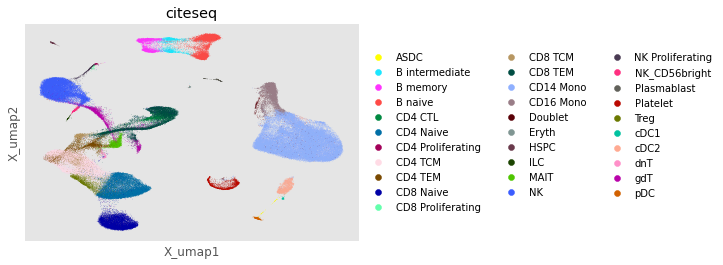

In [350]:
sc.pl.embedding(citeseq, "X_umap", color=['celltype.l2'], title="citeseq")

In [ ]:
sc.pl

In [341]:
citeseq.obs['celltype.l2']

L1_AAACCCAAGAAACTCA           CD14 Mono
L1_AAACCCAAGACATACA             CD4 TCM
L1_AAACCCACAACTGGTT           CD8 Naive
L1_AAACCCACACGTACTA                  NK
L1_AAACCCACAGCATACT           CD8 Naive
                              ...      
E2L8_TTTGTTGGTCGTGATT         CD8 Naive
E2L8_TTTGTTGGTGTGCCTG         CD14 Mono
E2L8_TTTGTTGGTTAGTTCG    B intermediate
E2L8_TTTGTTGGTTGGCTAT         CD16 Mono
E2L8_TTTGTTGTCTCATGGA         CD14 Mono
Name: celltype.l2, Length: 161764, dtype: object

In [327]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA
AAACAGCCAAAGCCTC-1,0,4431.0,2101
AAACAGCCAGAATGAC-1,0,10823.0,3895
AAACAGCCAGCTACGT-1,0,3371.0,1758
AAACAGCCAGGCCTTG-1,0,6386.0,2760
AAACAGCCATAAGGAC-1,0,335.0,162
...,...,...,...
TTTGTGTTCTAGCTAA-1,0,2772.0,1446
TTTGTTGGTACGCGCA-1,0,1897.0,1160
TTTGTTGGTATTTGCC-1,0,3858.0,1821
TTTGTTGGTGATTACG-1,0,2195.0,1304
